# 2 Problem formulation

Using the MLEnd Hums and Whistles dataset, build a machine learning pipeline that takes as an input a Potter or a StarWars audio segment and predicts its song label (either Harry or StarWars).

# 3 Machine Learning pipeline

Sample Path -> Preprocess -> Feathur extraction -> Modelling -> Result

# 4 Transformation stage

Environment set up

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re, pickle, glob


import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


Feature extraction use the reference method from start_kit file.

The input: 
+ an array constructed with all recordings' path.
+ a dataframe with each file names as first column and potter-or-starwars as second column.  

The output:  
+ an array contains all samples' feature which are in four dimension.
+ an array contains 'True' as 'Potter' and 'False' as 'StarWars'.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['song']=='Potter'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

# 5 Modelling 

Using the model train by SVM method, it define a hyperplane in an 4-dimensional space that distinctly classifies the data points.

In [ ]:
# After finishing training model, this function would be used to distinguish a specific recording is classified into 'potter' or 'starwars'
def distinguish(sample_path):

  sample_data, sample_name = raw_data(sample_path)

  X_sample = getXy(sample_data,sample_name, scale_audio=False, onlySingleDigit=False)[0]

  loaded_model = pickle.load(open("pima.pickle.dat", "rb"))

  if loaded_model.predict(X_sample)[0] == True:
    print('\n This songs is the Potter')
  else:
    print('\n This songs is the StarWars')

# 6 Methodology

Firstly, seperate public data into two part for training and validation.  
Then, standardize two groups of data, and use the SVM method to train the modle, and save it as local file 'pima.pickle.dat'.  
The last is use the validation accuracy to judge model performance.

In [ ]:
from sklearn.model_selection import train_test_split

def seperate(X, y, size):
  X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=size)
  return X_train, X_val, y_train, y_val

In [ ]:
from sklearn import svm

def model(X_train,X_val,y_train,y_val):
  mean = X_train.mean(0)
  sd =  X_train.std(0)

  X_train = (X_train-mean)/sd
  X_val  = (X_val-mean)/sd

  model  = svm.SVC(C=1,gamma=2)
  model.fit(X_train,y_train)

  yt_p = model.predict(X_train)
  yv_p = model.predict(X_val)

  pickle.dump(model, open("pima.pickle.dat", "wb"))

  print('Training Accuracy', np.mean(yt_p==y_train))
  print('Validation  Accuracy', np.mean(yv_p==y_val))
  print('The support vectors are', model.support_vectors_.shape)

In [ ]:
def SVC_method(X, y, size):
  X_train, X_val, y_train, y_val = seperate(X, y, size)
  model(X_train,X_val,y_train,y_val)

# 7 Dataset

Describe the dataset that you will use to create your models and validate them. If you need to preprocess it, do it here. Include visualisations too. You can visualise raw data samples or extracted features.

First of all, I use four zip files' intergration as my dataset(potter_part1|2, starwars_part1|2).  

However, due to some irregular naming result, not all files' names in same format, so I use a regular experission to help me prepross these name.

In [ ]:
import re
def potter(full_str):
  if re.findall('(.*)(P|p)otter(.*)', full_str):
    return 'Potter'
  else:
    return 'StarWars'

In [ ]:
def file_label(files):
  MLENDHW_table = [] 

  for file in files:
    file_name = file.split('/')[-1]
    song = potter(file.split('/')[-1])
    MLENDHW_table.append([file_name, song])
  return MLENDHW_table

In [ ]:
def dataframe(data):
  MLENDHW_df = pd.DataFrame(data,columns=['file_id','song']).set_index('file_id')
  return MLENDHW_df

In [ ]:
def raw_data(sample_path):
  files= glob.glob(sample_path)
  MLENDHW_table= dataframe(file_label(files))
  return files,MLENDHW_table

Visualise raw data sample

In [ ]:
# n is the position of selected sample
def visualize(files,n):
  fs = None # Sampling frequency. If None, fs would be 22050
  x, fs = librosa.load(files[n],sr=fs)
  t = np.arange(len(x))/fs
  plt.plot(t,x)
  plt.xlabel('time (sec)')
  plt.ylabel('amplitude')
  plt.show()
  display(ipd.Audio(files[n]))

# 8 Results

Carry out your experiments here, explain your results.

In [ ]:
dataset , name_table = raw_data('/content/drive/MyDrive/Data/Public_data/Basic_solution/*.wav')

In [ ]:
X , y = getXy(dataset,name_table, scale_audio=False, onlySingleDigit=False)

100%|██████████| 824/824 [44:22<00:00,  3.23s/it]


In [ ]:
SVC_method(X,y,0.3)

Training Accuracy 0.7725694444444444
Validation  Accuracy 0.5887096774193549
The support vectors are (471, 4)


In [ ]:
distinguish('/content/drive/MyDrive/Data/Public_data/Basic_solution/S1_whistle_2_Potter.wav')

100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


 This songs is the Potter


As you find, this sample is one of inccorectly distinguished. 

# 9 Conclusions

Your conclusions, improvements, etc should go here

In [ ]:
from sklearn.decomposition import PCA

def PCA_method(X):
  
  pca = PCA(n_components=2)

  projected = pca.fit_transform(X)

  return projected

In [ ]:
from google.colab import widgets
from sklearn import neighbors
from matplotlib.colors import ListedColormap

def knn_method(X, y ,size, MAX):

  mean = X.mean(0)
  sd =  X.std(0)

  X = (X-mean)/sd

  x_pca = PCA_method(X)

  x_train_pca, x_val_pca, y_train, y_val = seperate(x_pca, y, size)

  k_values = range(1,MAX,5)
  tb = widgets.TabBar([str(k) for k in k_values])

  cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])

  accuracy_t = dict.fromkeys(k_values)
  accuracy_v = dict.fromkeys(k_values)

  for k in k_values:
    with tb.output_to(str(k), select= (k < 2)):

      # First we create the kNN model
      knn = neighbors.KNeighborsClassifier(n_neighbors=k)
      knn.fit(x_train_pca, y_train)

      # Now we plot its decision regions
      coor1 = np.linspace(-10, 10, 100)
      coor2 = np.linspace(-10, 10, 100)
      x1_mesh, x2_mesh = np.meshgrid(coor1, coor2)
      yPred = knn.predict(np.c_[x1_mesh.ravel(), x2_mesh.ravel()])
      yPred = yPred.reshape(x2_mesh.shape)
      plt.figure(figsize=(7, 7))
      plt.pcolormesh(x1_mesh, x2_mesh, yPred, cmap=cmap_light)
      
      plt.xlabel('PC1')
      plt.ylabel('PC2')
      plt.legend(fontsize=12)
      plt.xlim(-10,10)
      plt.ylim(-10,10)
      plt.grid(True)


      # Finally we calculate the validation accuracy
      y_val_pred = knn.predict(x_val_pca)
      accuracy_v[k] = np.sum(y_val==y_val_pred)/len(y_val)

      # Training accuracy
      y_train_pred = knn.predict(x_train_pca)
      accuracy_t[k] = np.sum(y_train==y_train_pred)/len(y_train)

      print("The training accuracy for k=", k, "is ", accuracy_t[k])
      print("The validation accuracy for k=", k, "is ", accuracy_v[k])


  # Here we predict the value of the validation accuracy as a function of k
  plt.figure(figsize=(7, 7))
  plt.plot(k_values, list(accuracy_v.values()), '--*', linewidth=2)
  plt.xlabel("k", fontsize=12)
  plt.ylabel("Validation accuracy", fontsize=12)
  plt.grid(alpha=0.2)
  plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 1 is  1.0
The validation accuracy for k= 1 is  0.5403225806451613


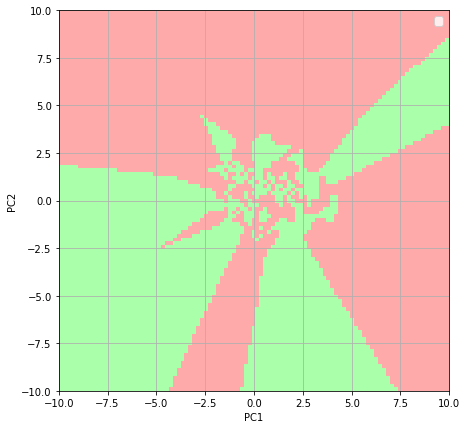

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 6 is  0.7065972222222222
The validation accuracy for k= 6 is  0.6209677419354839


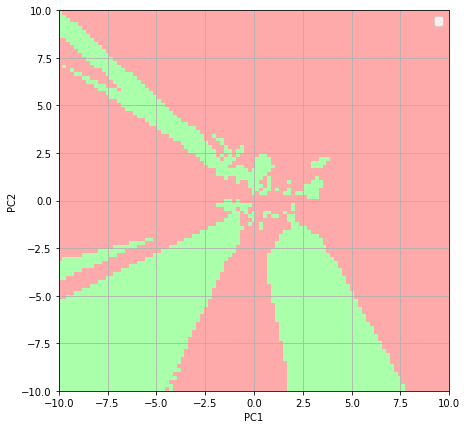

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 11 is  0.6805555555555556
The validation accuracy for k= 11 is  0.6048387096774194


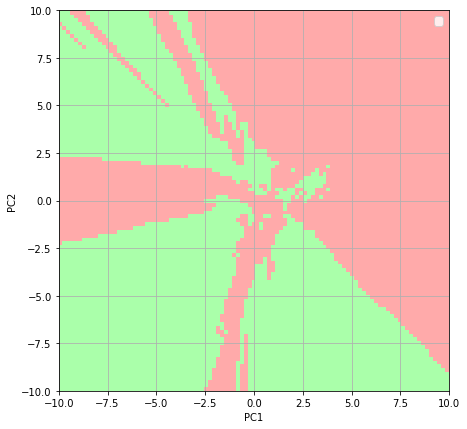

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 16 is  0.6371527777777778
The validation accuracy for k= 16 is  0.6088709677419355


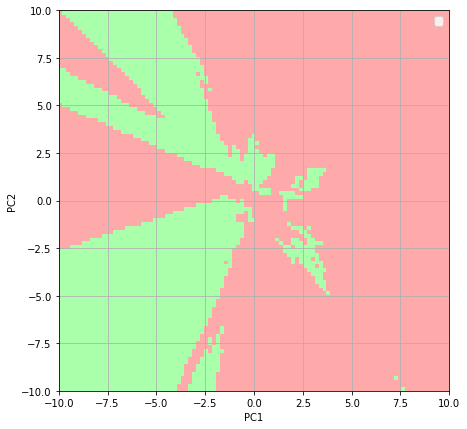

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 21 is  0.6371527777777778
The validation accuracy for k= 21 is  0.6088709677419355


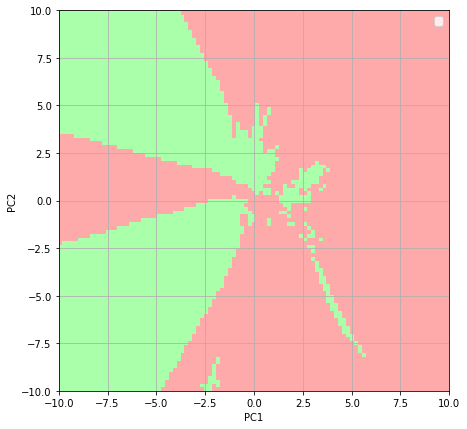

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 26 is  0.625
The validation accuracy for k= 26 is  0.6048387096774194


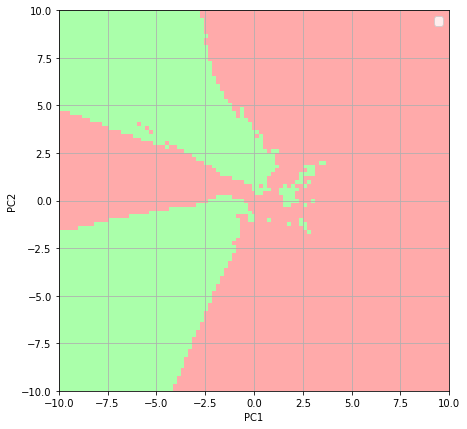

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 31 is  0.6458333333333334
The validation accuracy for k= 31 is  0.6169354838709677


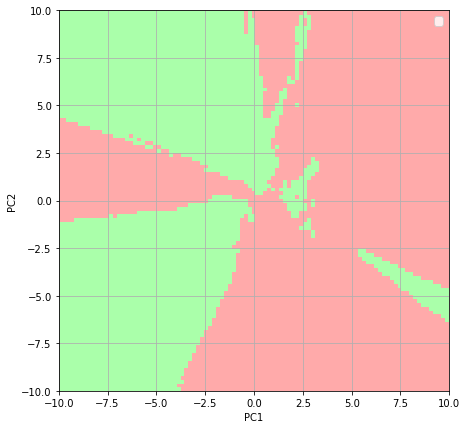

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 36 is  0.6197916666666666
The validation accuracy for k= 36 is  0.6169354838709677


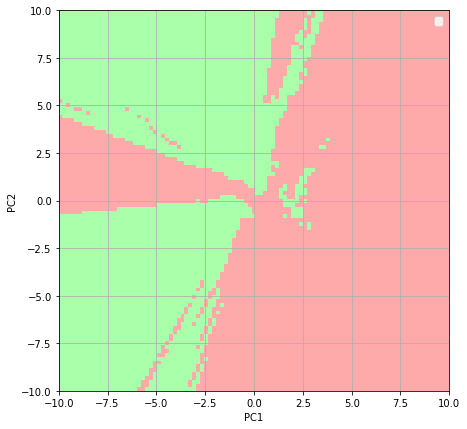

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 41 is  0.6076388888888888
The validation accuracy for k= 41 is  0.6088709677419355


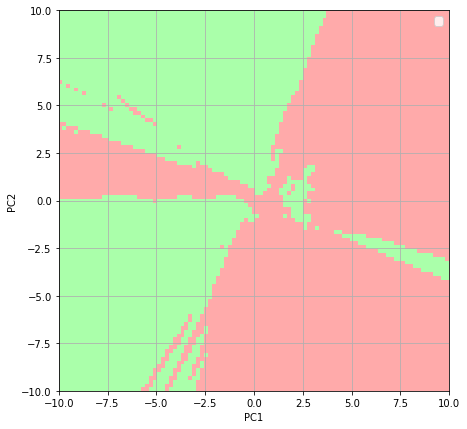

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 46 is  0.6267361111111112
The validation accuracy for k= 46 is  0.6209677419354839


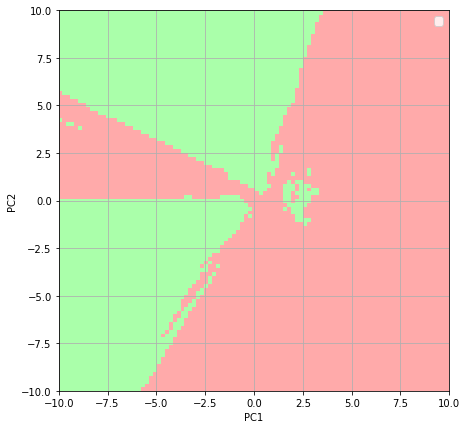

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 51 is  0.6197916666666666
The validation accuracy for k= 51 is  0.6451612903225806


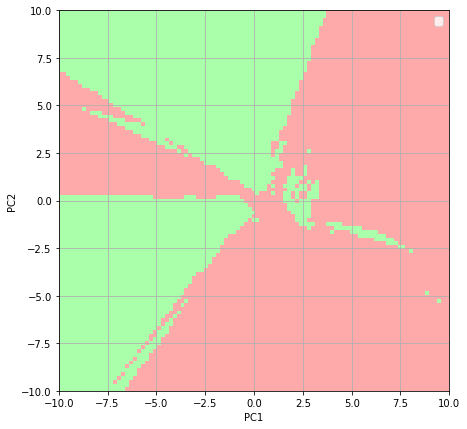

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 56 is  0.6059027777777778
The validation accuracy for k= 56 is  0.6411290322580645


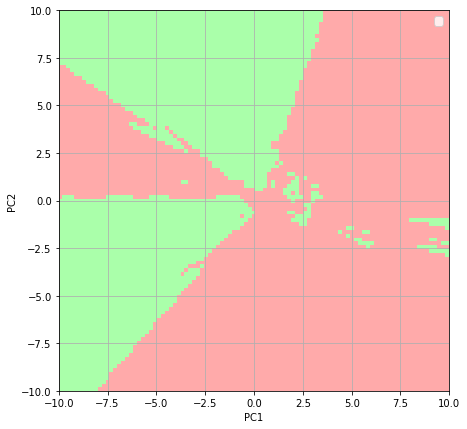

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 61 is  0.609375
The validation accuracy for k= 61 is  0.6451612903225806


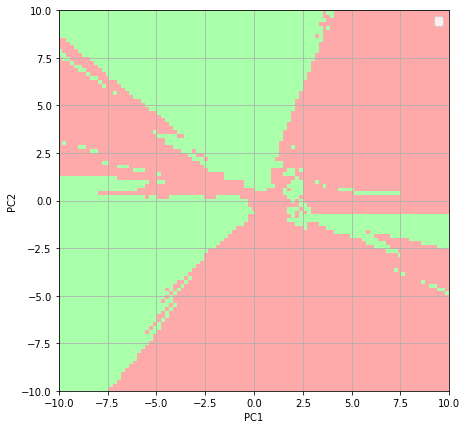

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 66 is  0.6111111111111112
The validation accuracy for k= 66 is  0.6169354838709677


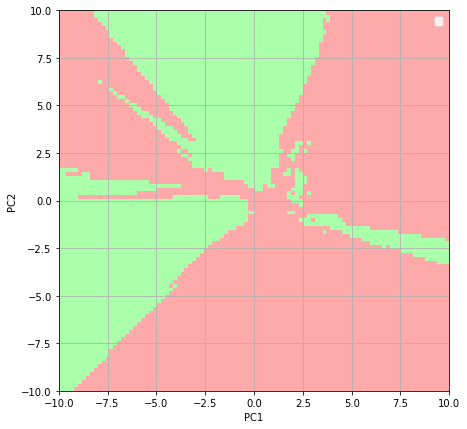

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 71 is  0.6059027777777778
The validation accuracy for k= 71 is  0.6169354838709677


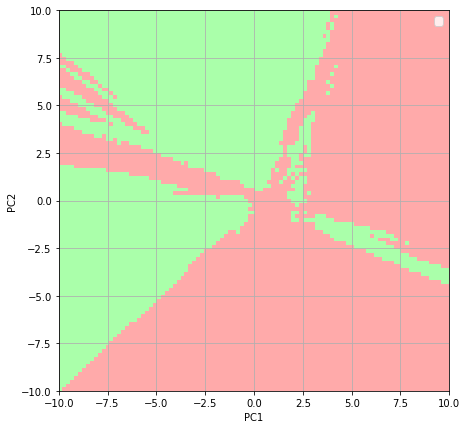

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 76 is  0.6111111111111112
The validation accuracy for k= 76 is  0.6129032258064516


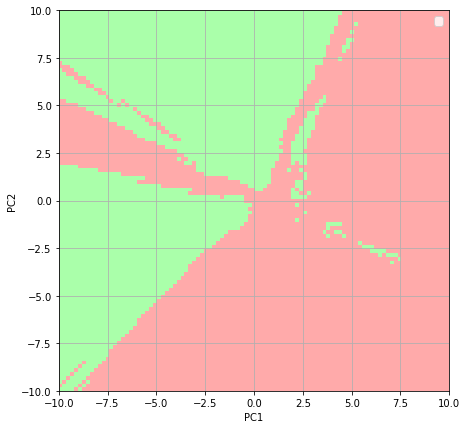

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 81 is  0.6041666666666666
The validation accuracy for k= 81 is  0.6088709677419355


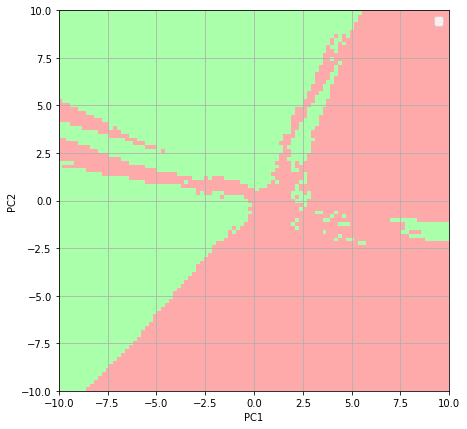

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 86 is  0.6024305555555556
The validation accuracy for k= 86 is  0.5846774193548387


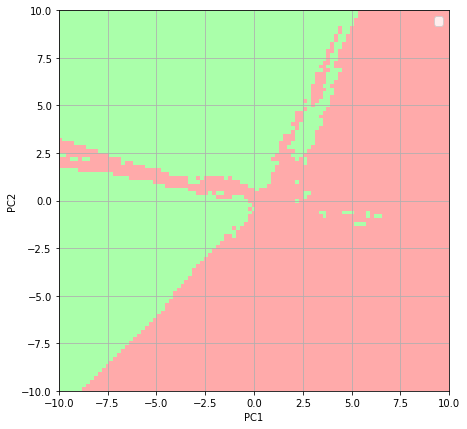

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 91 is  0.609375
The validation accuracy for k= 91 is  0.6129032258064516


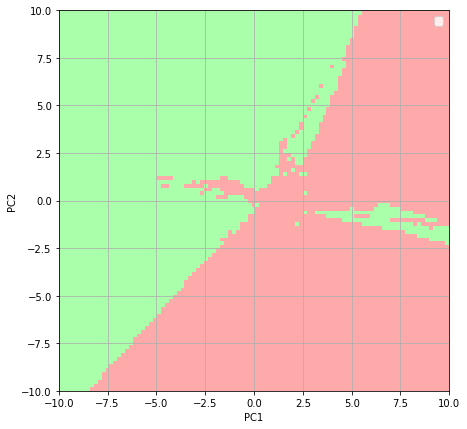

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 96 is  0.6006944444444444
The validation accuracy for k= 96 is  0.6048387096774194


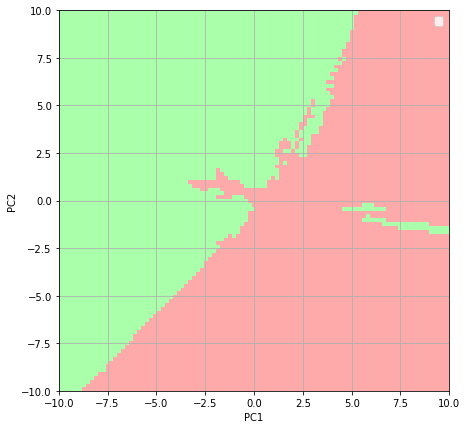

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 101 is  0.6059027777777778
The validation accuracy for k= 101 is  0.6008064516129032


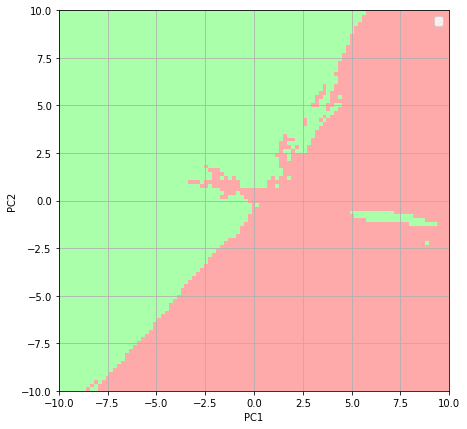

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 106 is  0.5989583333333334
The validation accuracy for k= 106 is  0.6008064516129032


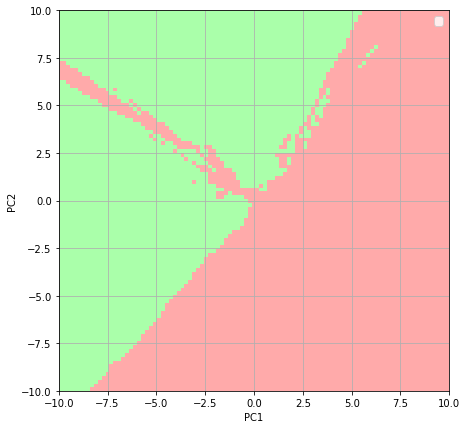

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 111 is  0.6006944444444444
The validation accuracy for k= 111 is  0.6048387096774194


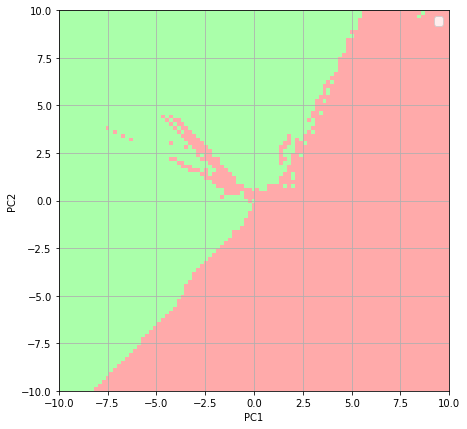

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 116 is  0.5972222222222222
The validation accuracy for k= 116 is  0.6169354838709677


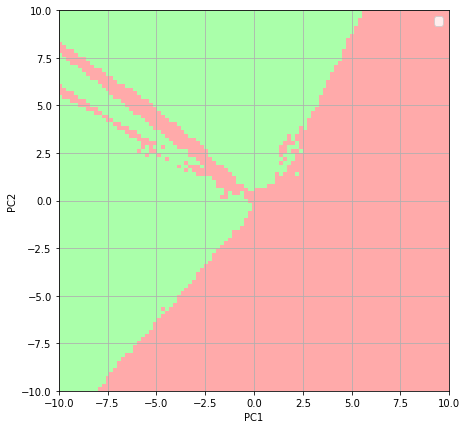

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 121 is  0.5868055555555556
The validation accuracy for k= 121 is  0.6048387096774194


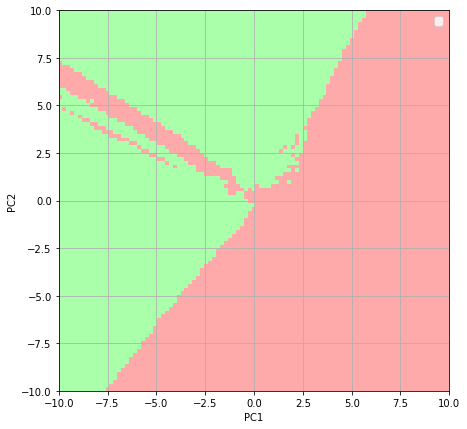

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 126 is  0.5798611111111112
The validation accuracy for k= 126 is  0.5967741935483871


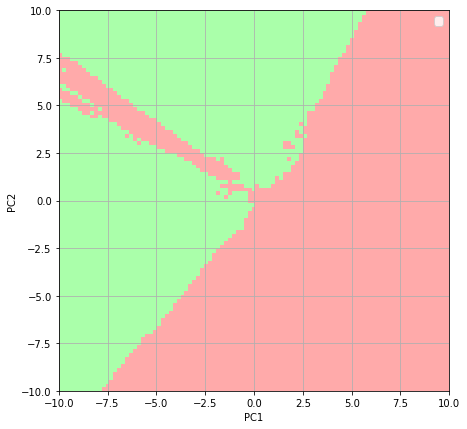

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 131 is  0.5763888888888888
The validation accuracy for k= 131 is  0.5564516129032258


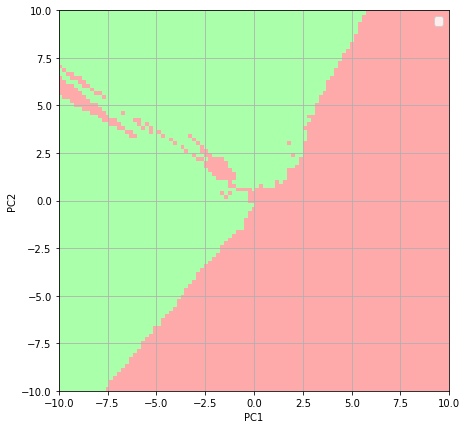

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 136 is  0.5677083333333334
The validation accuracy for k= 136 is  0.5524193548387096


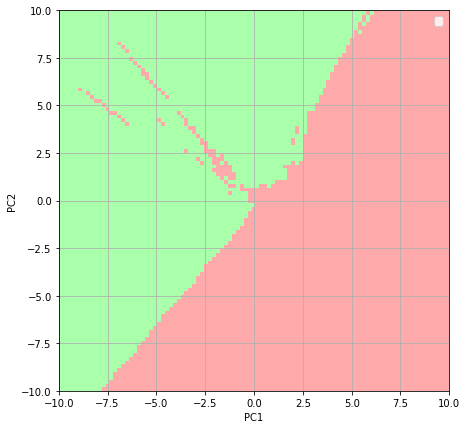

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 141 is  0.5798611111111112
The validation accuracy for k= 141 is  0.5645161290322581


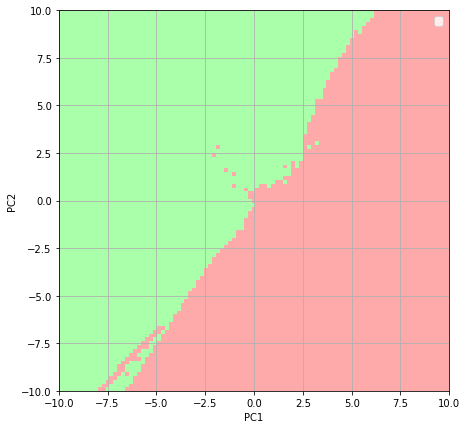

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 146 is  0.5694444444444444
The validation accuracy for k= 146 is  0.5685483870967742


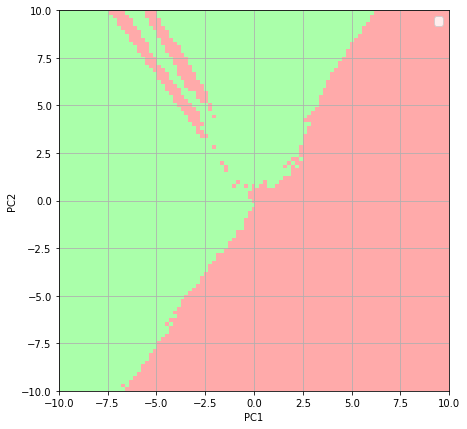

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 151 is  0.5659722222222222
The validation accuracy for k= 151 is  0.5604838709677419


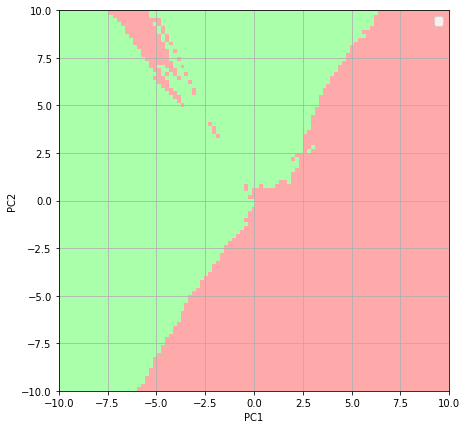

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 156 is  0.5642361111111112
The validation accuracy for k= 156 is  0.5645161290322581


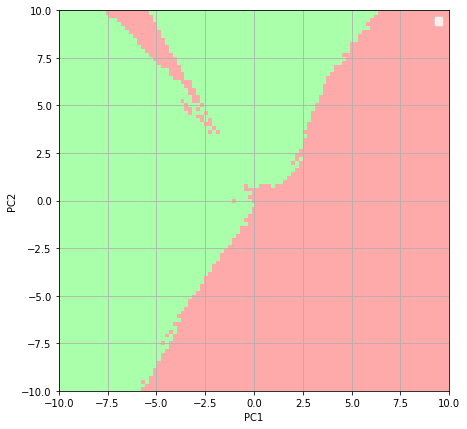

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 161 is  0.5694444444444444
The validation accuracy for k= 161 is  0.5564516129032258


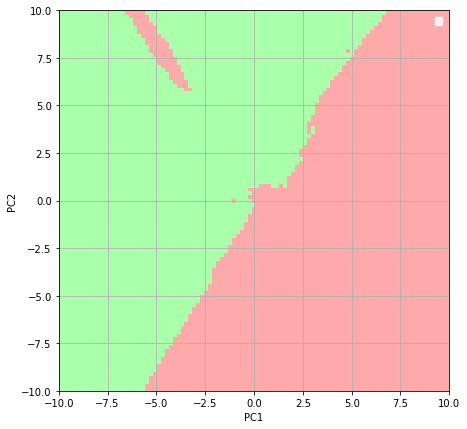

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 166 is  0.5520833333333334
The validation accuracy for k= 166 is  0.532258064516129


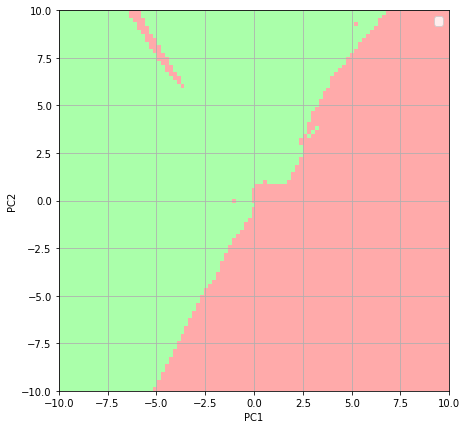

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 171 is  0.5625
The validation accuracy for k= 171 is  0.5564516129032258


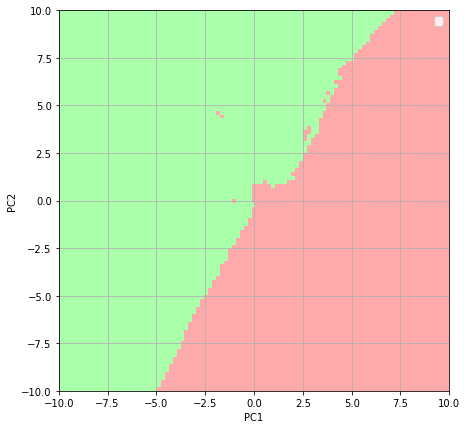

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 176 is  0.5625
The validation accuracy for k= 176 is  0.532258064516129


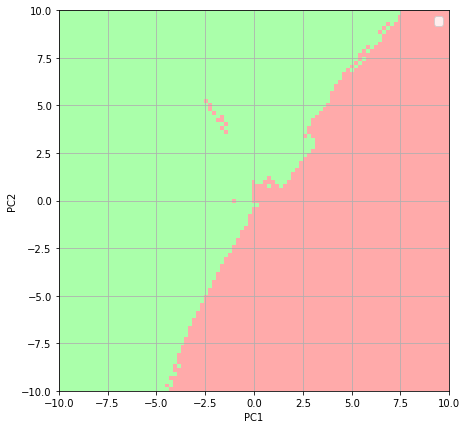

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 181 is  0.5607638888888888
The validation accuracy for k= 181 is  0.5443548387096774


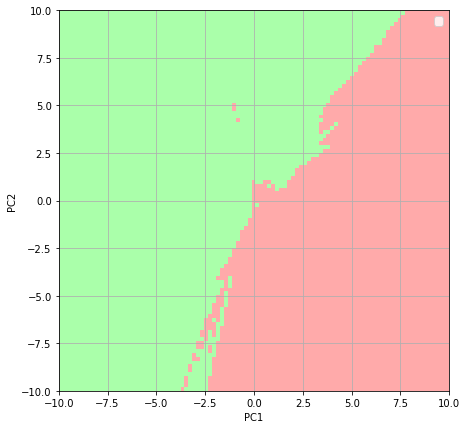

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 186 is  0.5451388888888888
The validation accuracy for k= 186 is  0.5403225806451613


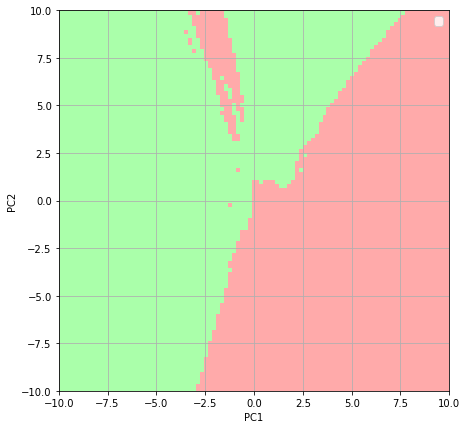

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 191 is  0.5434027777777778
The validation accuracy for k= 191 is  0.5120967741935484


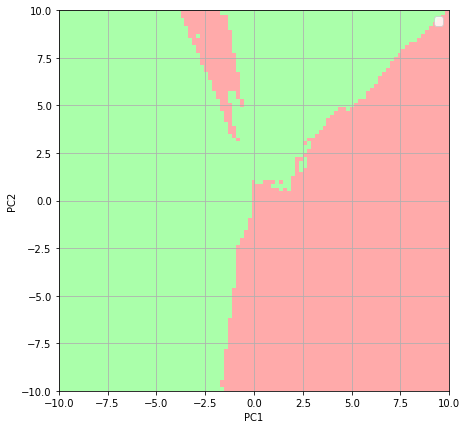

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 196 is  0.5451388888888888
The validation accuracy for k= 196 is  0.5201612903225806


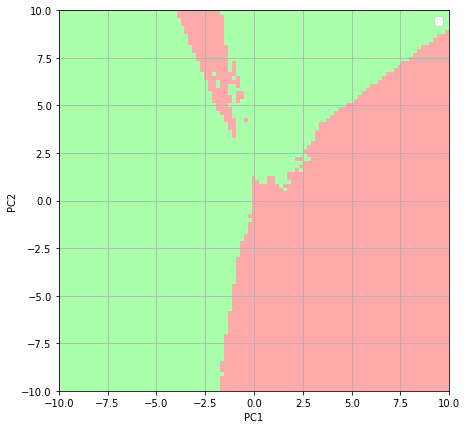

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 201 is  0.5520833333333334
The validation accuracy for k= 201 is  0.532258064516129


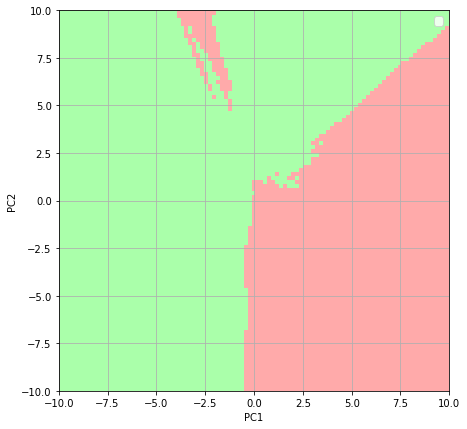

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 206 is  0.5538194444444444
The validation accuracy for k= 206 is  0.5443548387096774


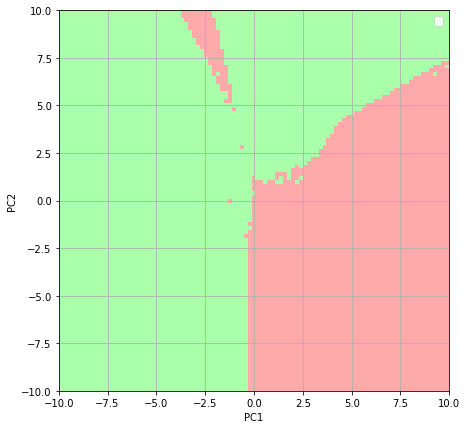

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 211 is  0.5520833333333334
The validation accuracy for k= 211 is  0.5443548387096774


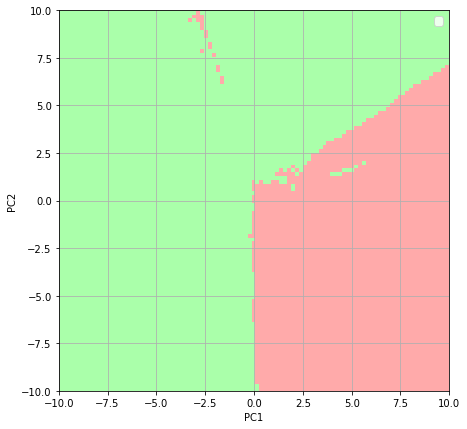

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 216 is  0.5538194444444444
The validation accuracy for k= 216 is  0.5362903225806451


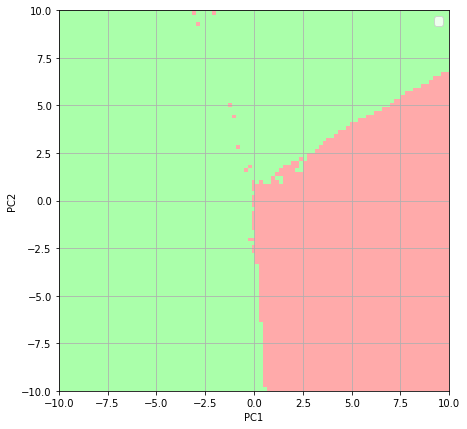

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 221 is  0.5399305555555556
The validation accuracy for k= 221 is  0.5201612903225806


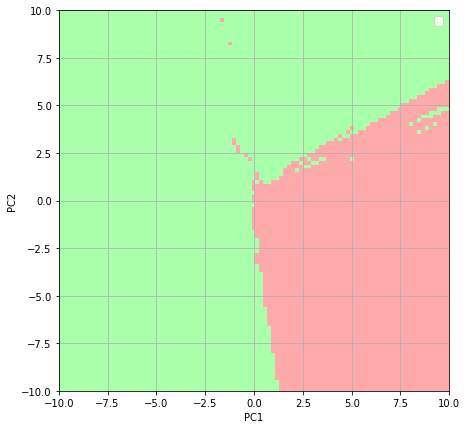

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 226 is  0.5381944444444444
The validation accuracy for k= 226 is  0.5201612903225806


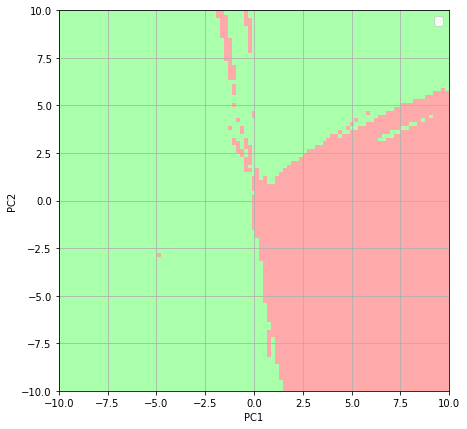

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 231 is  0.5399305555555556
The validation accuracy for k= 231 is  0.532258064516129


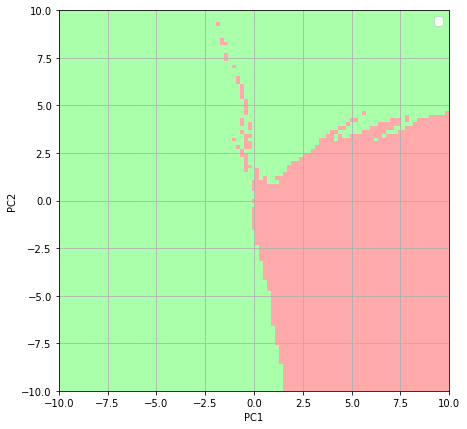

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 236 is  0.5295138888888888
The validation accuracy for k= 236 is  0.5161290322580645


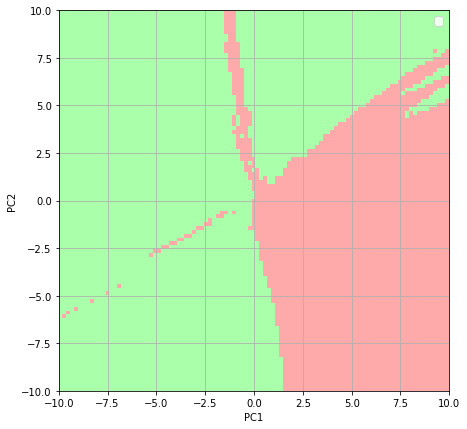

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 241 is  0.5364583333333334
The validation accuracy for k= 241 is  0.5161290322580645


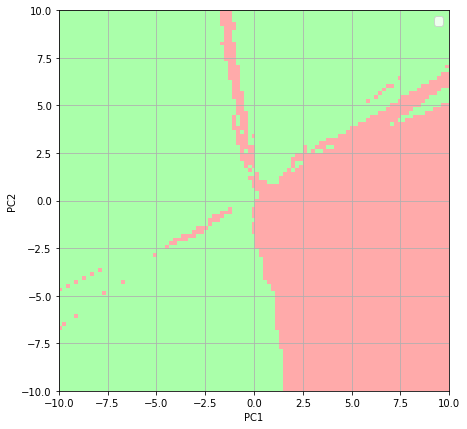

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 246 is  0.5295138888888888
The validation accuracy for k= 246 is  0.5080645161290323


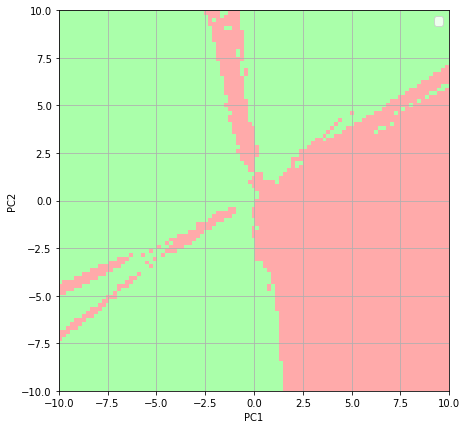

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 251 is  0.5069444444444444
The validation accuracy for k= 251 is  0.4717741935483871


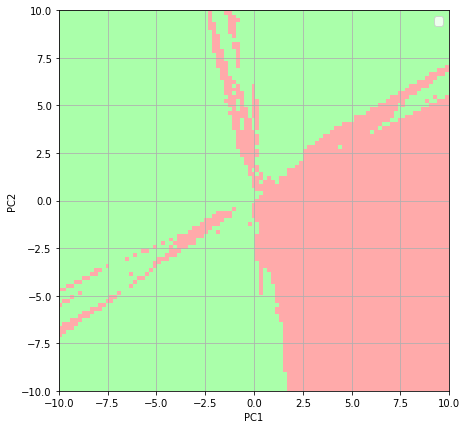

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 256 is  0.5017361111111112
The validation accuracy for k= 256 is  0.4717741935483871


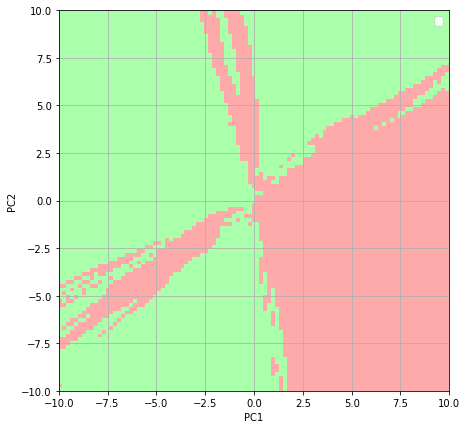

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 261 is  0.4930555555555556
The validation accuracy for k= 261 is  0.4637096774193548


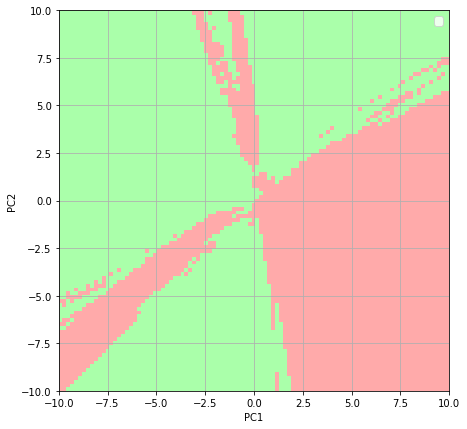

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 266 is  0.4895833333333333
The validation accuracy for k= 266 is  0.47580645161290325


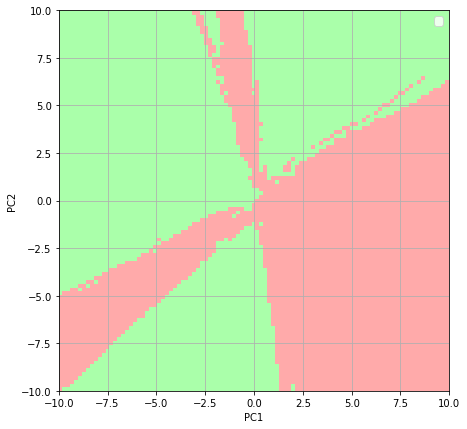

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 271 is  0.5052083333333334
The validation accuracy for k= 271 is  0.4637096774193548


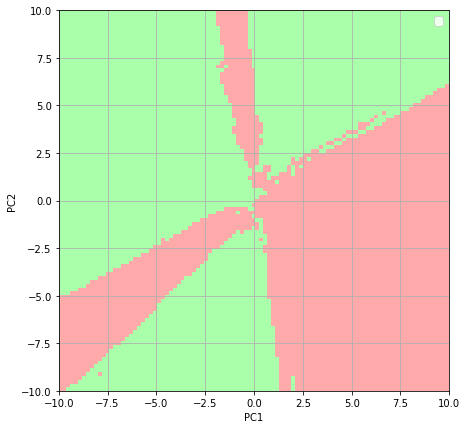

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 276 is  0.5104166666666666
The validation accuracy for k= 276 is  0.46774193548387094


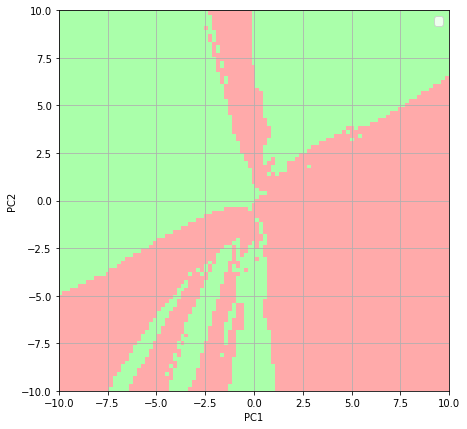

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 281 is  0.5052083333333334
The validation accuracy for k= 281 is  0.4596774193548387


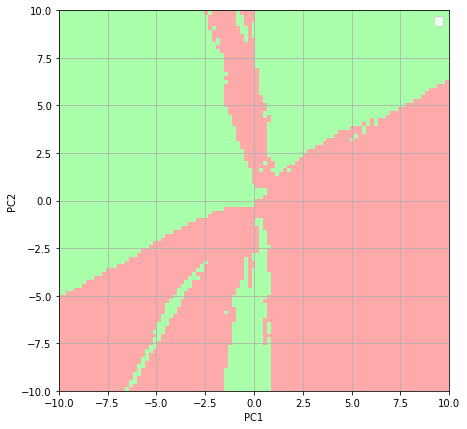

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 286 is  0.5
The validation accuracy for k= 286 is  0.45564516129032256


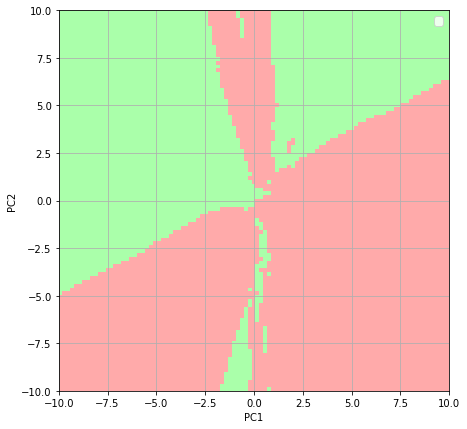

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 291 is  0.4791666666666667
The validation accuracy for k= 291 is  0.45161290322580644


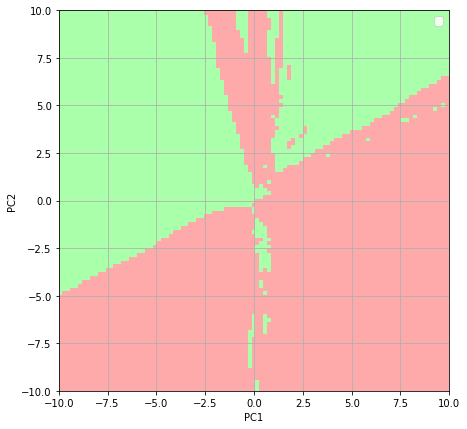

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 296 is  0.4739583333333333
The validation accuracy for k= 296 is  0.4475806451612903


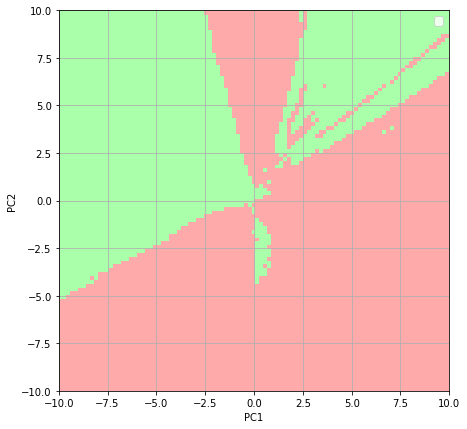

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 301 is  0.4739583333333333
The validation accuracy for k= 301 is  0.42338709677419356


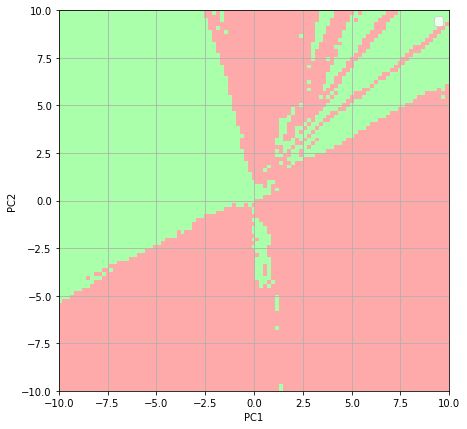

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 306 is  0.46875
The validation accuracy for k= 306 is  0.4637096774193548


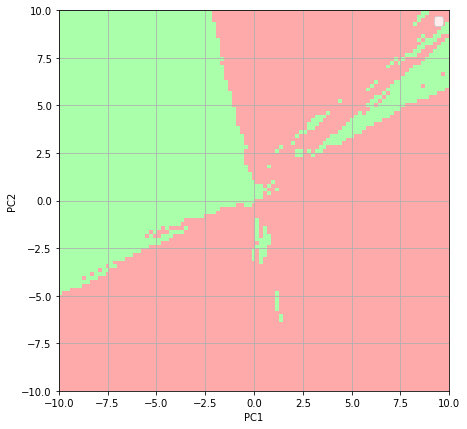

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 311 is  0.4791666666666667
The validation accuracy for k= 311 is  0.47580645161290325


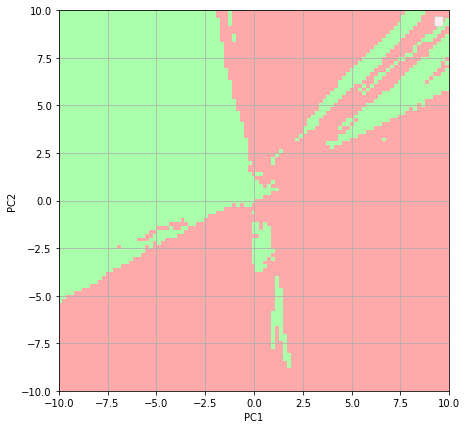

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 316 is  0.4861111111111111
The validation accuracy for k= 316 is  0.5


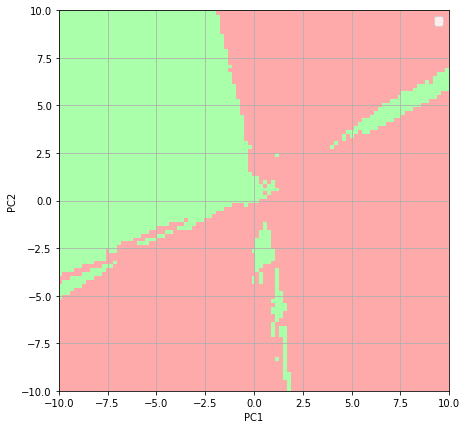

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 321 is  0.5
The validation accuracy for k= 321 is  0.4959677419354839


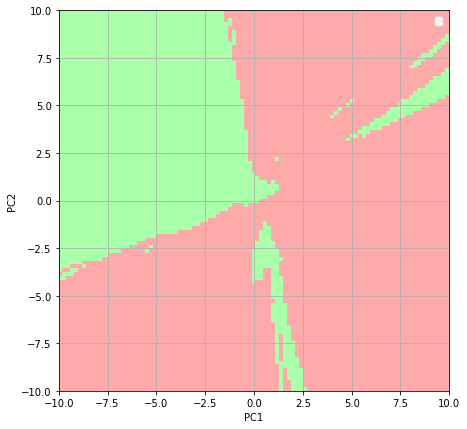

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 326 is  0.5086805555555556
The validation accuracy for k= 326 is  0.5120967741935484


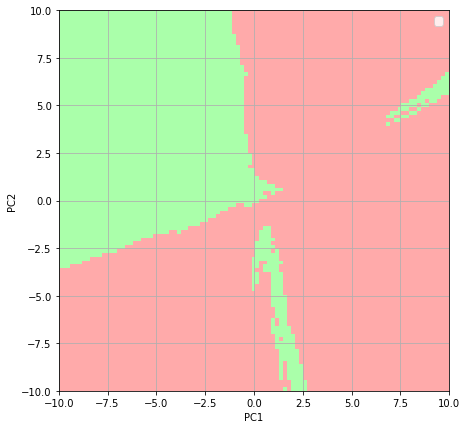

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 331 is  0.5208333333333334
The validation accuracy for k= 331 is  0.5040322580645161


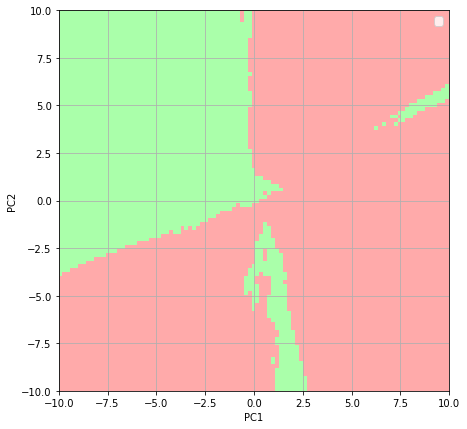

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 336 is  0.5173611111111112
The validation accuracy for k= 336 is  0.5080645161290323


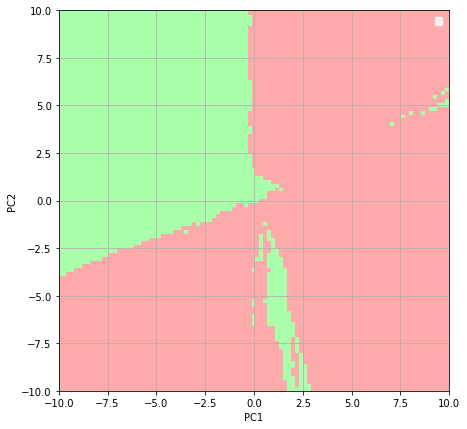

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 341 is  0.5260416666666666
The validation accuracy for k= 341 is  0.5282258064516129


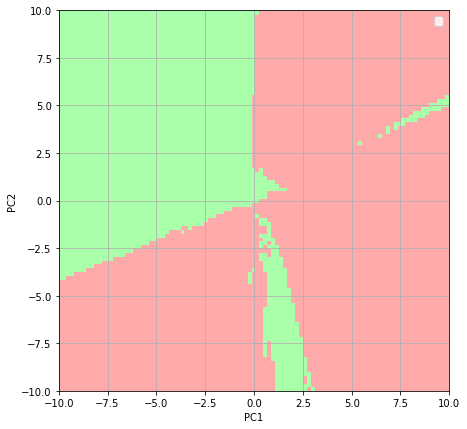

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 346 is  0.5364583333333334
The validation accuracy for k= 346 is  0.532258064516129


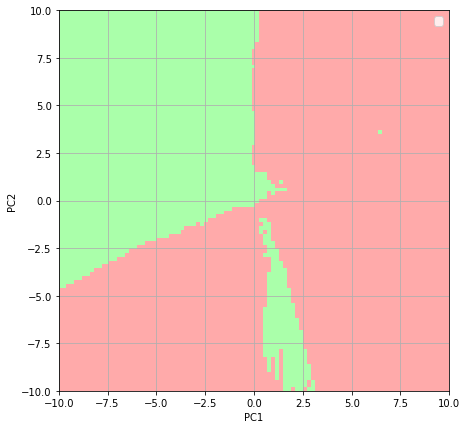

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 351 is  0.5364583333333334
The validation accuracy for k= 351 is  0.5201612903225806


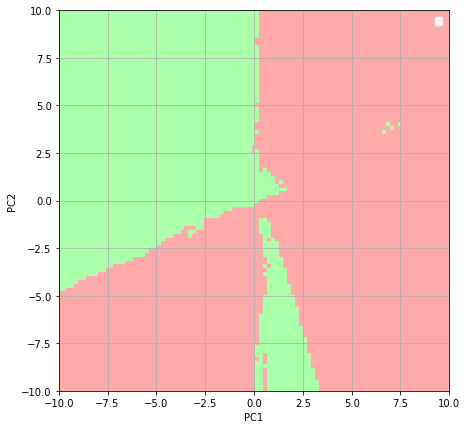

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 356 is  0.5243055555555556
The validation accuracy for k= 356 is  0.5201612903225806


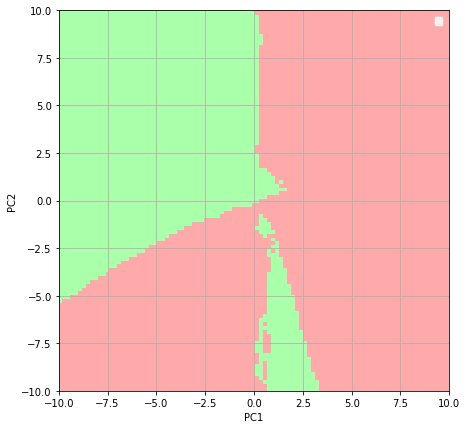

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 361 is  0.5295138888888888
The validation accuracy for k= 361 is  0.5080645161290323


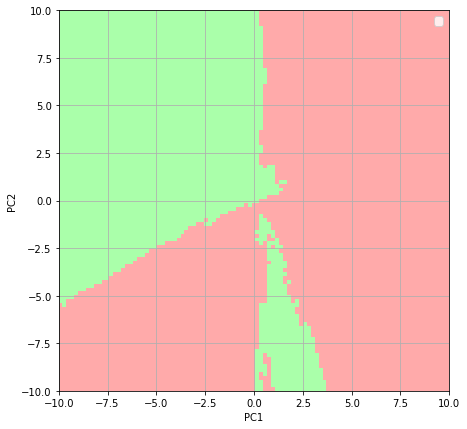

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 366 is  0.5329861111111112
The validation accuracy for k= 366 is  0.5201612903225806


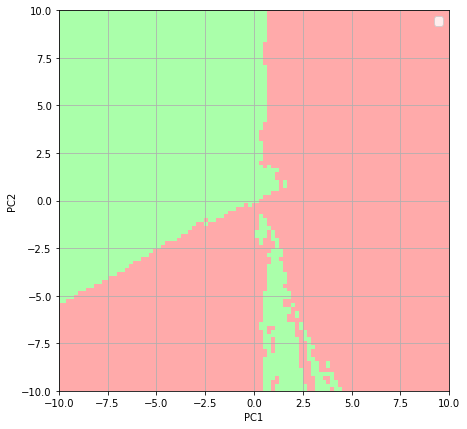

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 371 is  0.5295138888888888
The validation accuracy for k= 371 is  0.5080645161290323


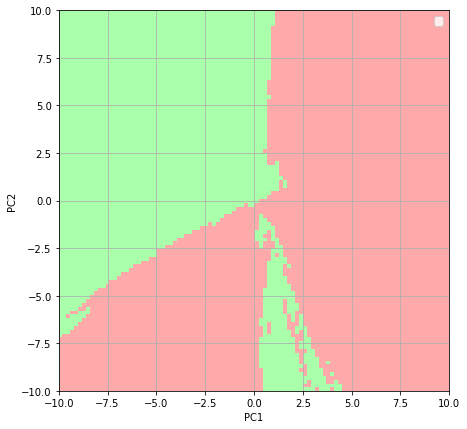

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 376 is  0.5329861111111112
The validation accuracy for k= 376 is  0.5120967741935484


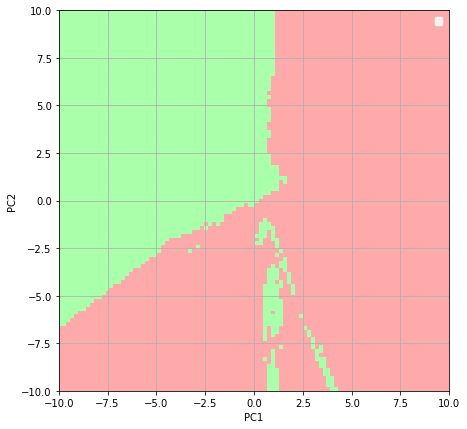

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 381 is  0.5364583333333334
The validation accuracy for k= 381 is  0.5282258064516129


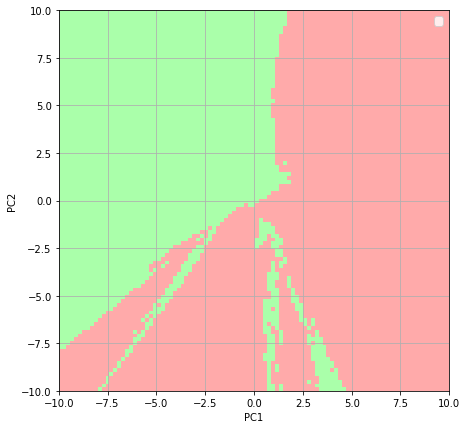

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 386 is  0.5260416666666666
The validation accuracy for k= 386 is  0.5403225806451613


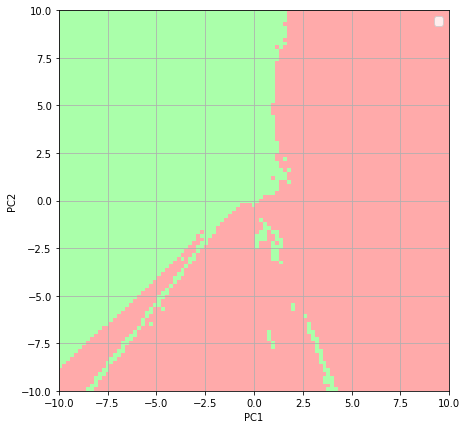

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 391 is  0.53125
The validation accuracy for k= 391 is  0.5080645161290323


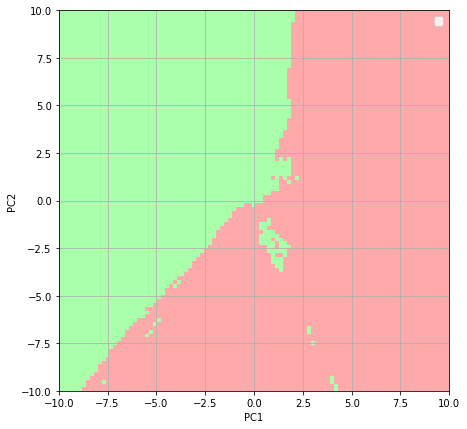

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 396 is  0.5381944444444444
The validation accuracy for k= 396 is  0.5403225806451613


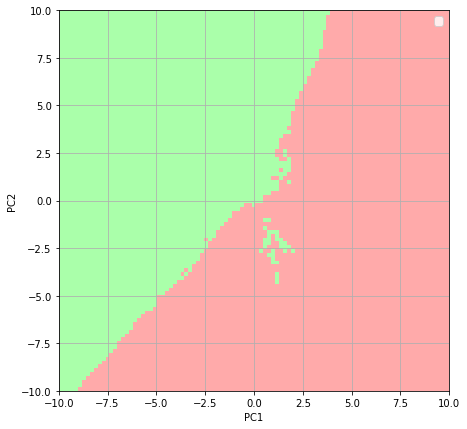

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 401 is  0.5434027777777778
The validation accuracy for k= 401 is  0.5403225806451613


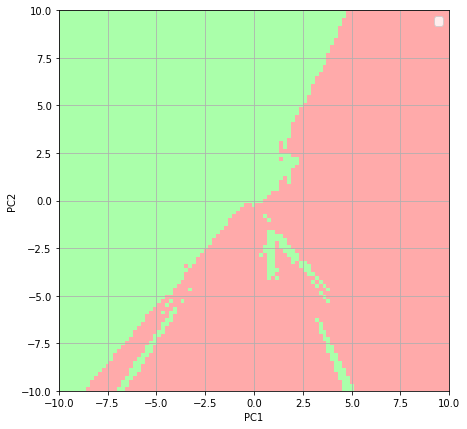

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 406 is  0.5364583333333334
The validation accuracy for k= 406 is  0.5403225806451613


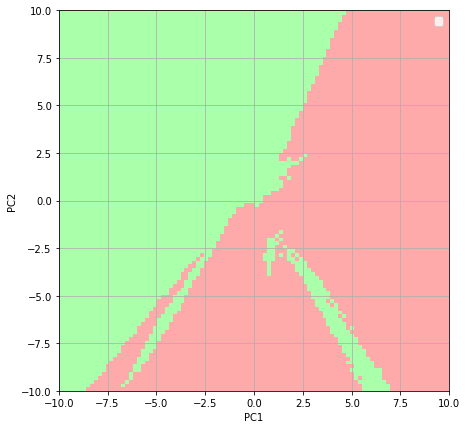

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 411 is  0.5399305555555556
The validation accuracy for k= 411 is  0.5443548387096774


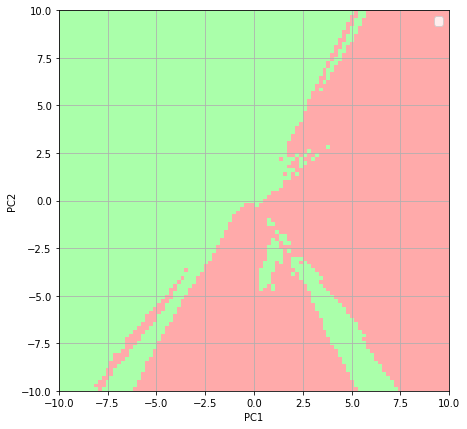

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 416 is  0.5434027777777778
The validation accuracy for k= 416 is  0.5403225806451613


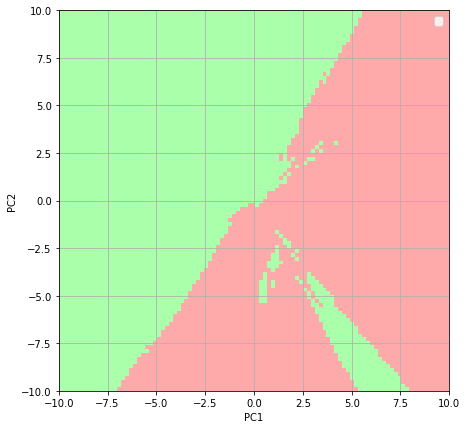

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 421 is  0.5329861111111112
The validation accuracy for k= 421 is  0.5443548387096774


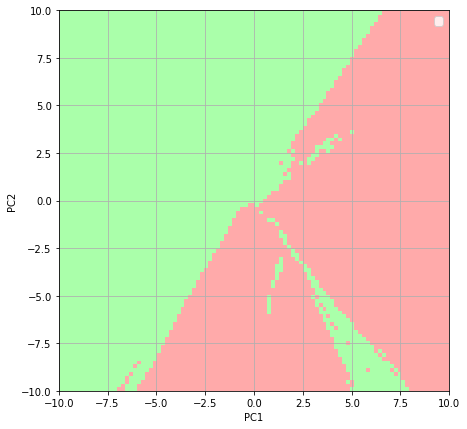

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 426 is  0.5451388888888888
The validation accuracy for k= 426 is  0.5403225806451613


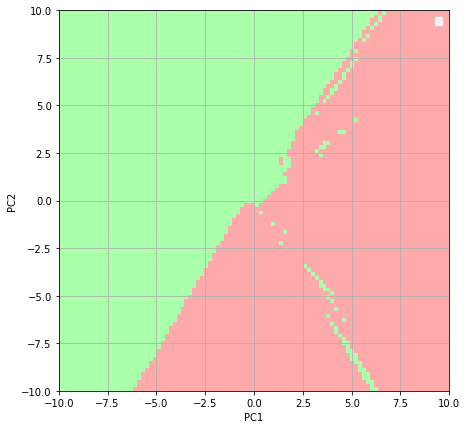

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 431 is  0.5486111111111112
The validation accuracy for k= 431 is  0.532258064516129


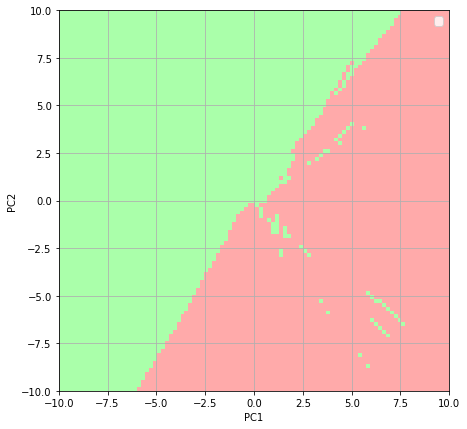

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 436 is  0.5503472222222222
The validation accuracy for k= 436 is  0.5282258064516129


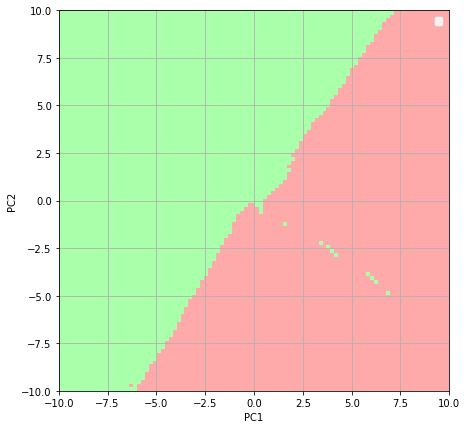

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 441 is  0.5434027777777778
The validation accuracy for k= 441 is  0.5282258064516129


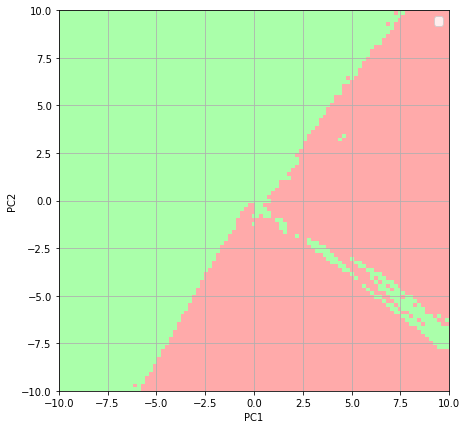

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 446 is  0.5572916666666666
The validation accuracy for k= 446 is  0.5524193548387096


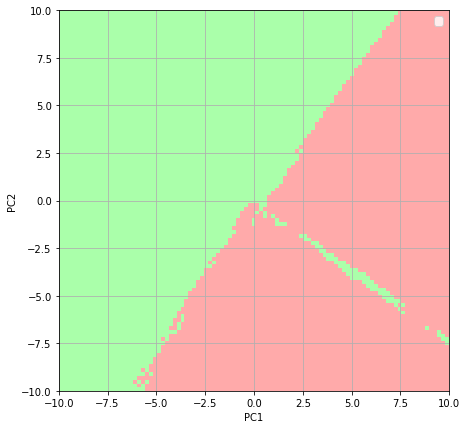

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 451 is  0.5520833333333334
The validation accuracy for k= 451 is  0.5483870967741935


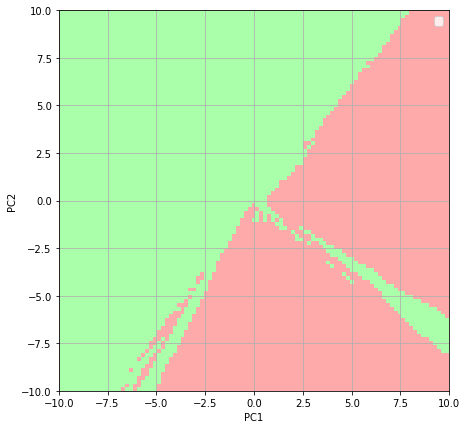

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 456 is  0.546875
The validation accuracy for k= 456 is  0.5524193548387096


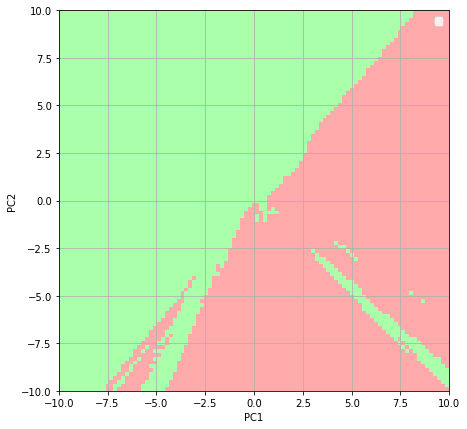

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 461 is  0.5347222222222222
The validation accuracy for k= 461 is  0.5362903225806451


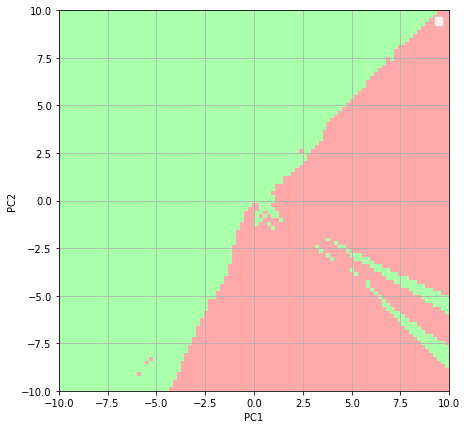

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 466 is  0.5486111111111112
The validation accuracy for k= 466 is  0.532258064516129


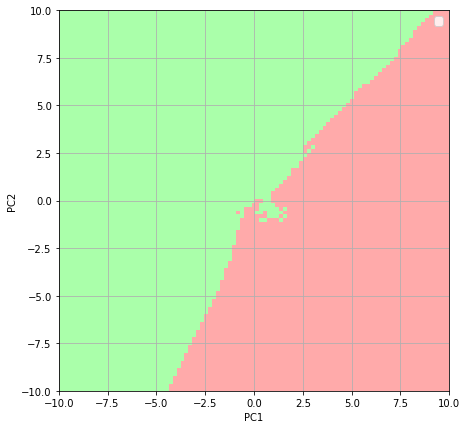

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 471 is  0.5503472222222222
The validation accuracy for k= 471 is  0.532258064516129


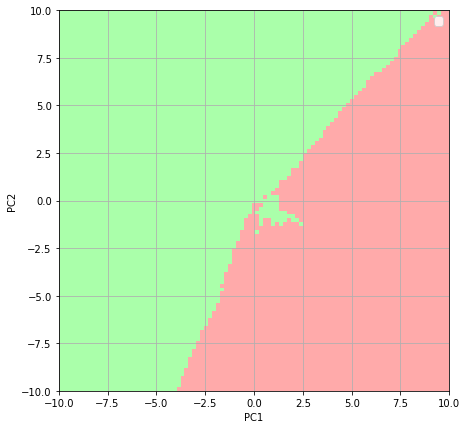

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 476 is  0.5555555555555556
The validation accuracy for k= 476 is  0.5403225806451613


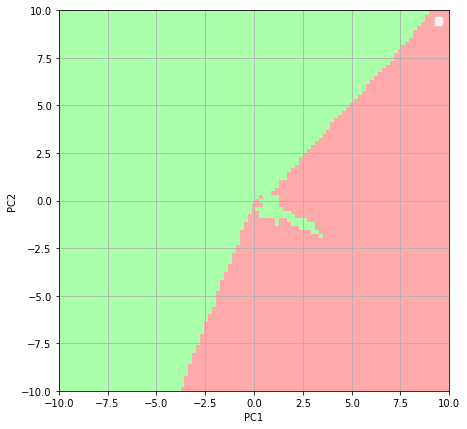

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 481 is  0.5399305555555556
The validation accuracy for k= 481 is  0.532258064516129


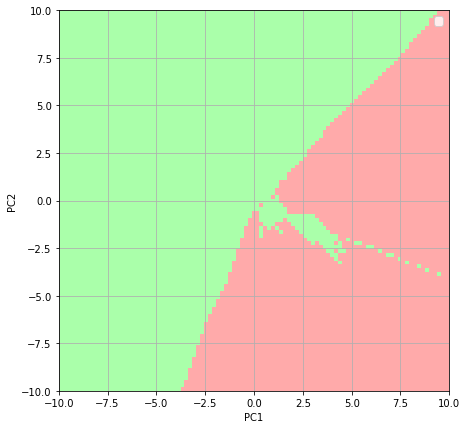

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 486 is  0.5625
The validation accuracy for k= 486 is  0.5362903225806451


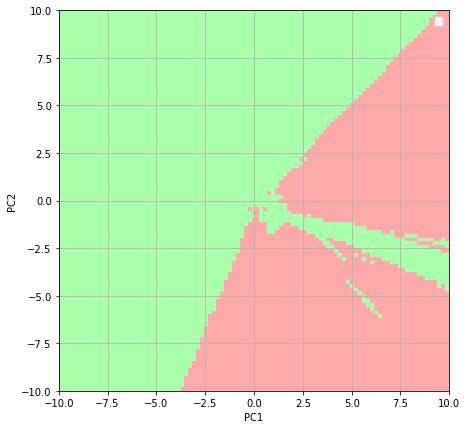

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 491 is  0.5520833333333334
The validation accuracy for k= 491 is  0.5443548387096774


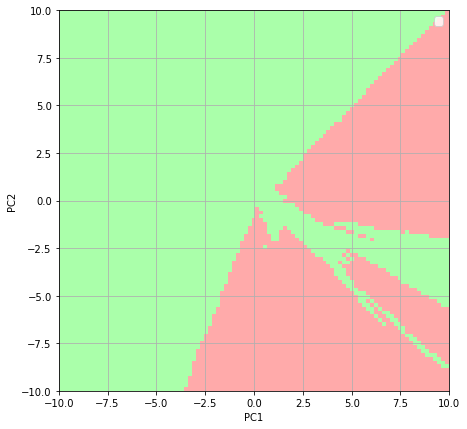

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


The training accuracy for k= 496 is  0.5434027777777778
The validation accuracy for k= 496 is  0.5685483870967742


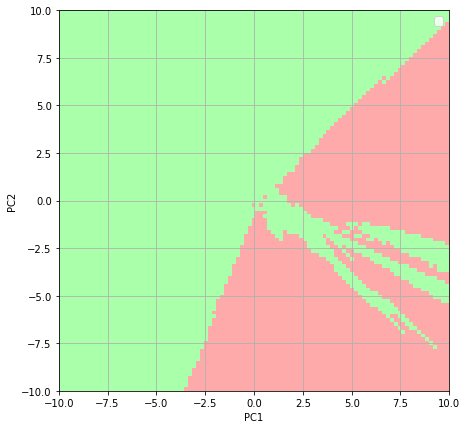

<IPython.core.display.Javascript object>

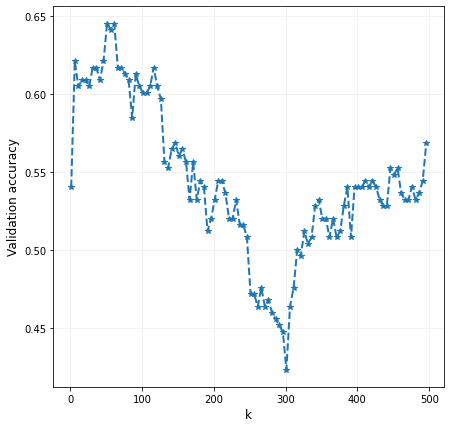

In [ ]:
knn_method(X,y,0.3,500)

Except for SVC method, I tried to deal with this problem with the other supervised learning method, Knn , to train the model. Besides, after initial standardization, I use PCA method to complete dimension decline so that the data point could be easily visualized.  
As we can see from above graphs,  the highest point of validation accuracy is reached when k is around 50, and the accuracy is approaching 0.6 which is near then SVM method. 